# A CNN leveraging Sentinel Images

authors: Michael Darcy

This notebook contains a convolutional neural network implementation for the Lacuna Field Center prediction challenge. The network architecture is based on the pretrained ResNet152 network, available through PyTorch, trained with Absolute Mean Loss according to the competition rules. The ResNet152 output layer was modified to two floating-point classes to predict the x and y displacement. Only the images were used from the dataset. 

In [11]:
import pandas_path
from IPython.display import Image
from PIL import Image as pil_image

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import warnings

import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision.models as models
from tqdm import tqdm
from torch import nn

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product as iterp

%load_ext nb_black

# this path is for the images
datapath = "C:/Users/micha/OneDrive/Documents/GitHub/Lacuna/sentinel/"

# this path is for the training and test csv files
DATA_PATH = "C:/Users/micha/OneDrive/Documents/GitHub/Lacuna/"

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

We probably don't need some of these but there's all the packages. Next we'll parse individual sentinel images into a 120x120x3 RGB image for packing into the right shape for ResNet152, a pretrained image classification network.

In [12]:
def getSentinelTimeData(path2tif, filterCloudy=True):
    """
    process input Sentinel TIFF file to map its contents into a dictionary
    with filter keys and monthly images as values
    
    note: it won't process images with number of channels other than 192
    
    when filterCloudy flag is True:
    - excludes cloudy images based on cloud-mask (filter#16)
    - final dictionary contains 13 real filter data
    """
    
    # filter and month IDs
    filters = [1,2,3]
    months  = [1,2,3,4,5,6,7,8,9]

    # read TIFF file into 3D array
    img = rdtif(path2tif)
    
    # if it's one of the images with too few months, just take the months we have and leave the rest blank
    if img.shape[-1] != 192: months = [1,2,3,4,5,6]
        
    # initialize the dict with empty list for each filter, including cropping all images to the minimum size across all data
    d = np.array(np.zeros((3,3,3,40,40)))
    # this will pack the different channels into different elements of d
    for i, j in iterp(months, filters):

        channel = ((i) * 16) + j
        
        tile_x = (i%3)-1
        tile_y = int(np.floor(i/3))%3
        #print (j, tile_x, tile_y)
        d[j-1][tile_y][tile_x] = img[:40, :40, channel]
    
    # now we are going to tile all the months that we have into a single channel, and separate the different RGB sentinel channels
    stacks = {}
    
    
    for filt in filters:
        stacks[filt] = np.hstack(np.hstack(d[filt-1]))
        
    return stacks


<IPython.core.display.Javascript object>

OK let's try this out with a random fieldID. We'll check the shape to make sure things are working at this stage.

In [13]:

from skimage.io import imread as rdtif

fieldID = 'ff4174be'
fname = f'{fieldID}.tif'
img = rdtif(f'{datapath}{fname}')

img.shape



(41, 41, 192)

<IPython.core.display.Javascript object>

Next, lets plot the tiled images we have so far using the function we wrote above. Note that the images are not normalized in the image parsing function because we are going to have to normalize them later in the pipeline anyways.

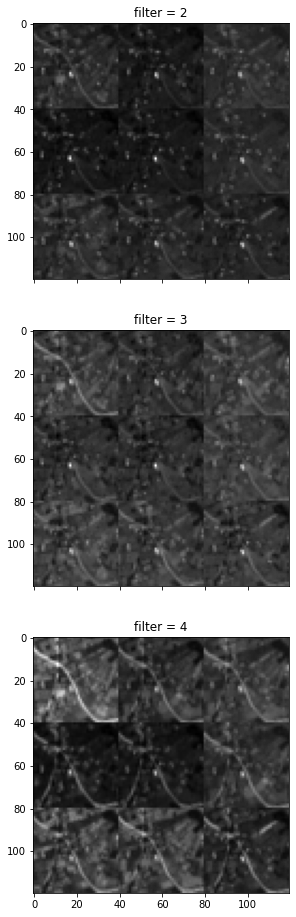

<IPython.core.display.Javascript object>

In [14]:
filters = [1, 2, 3]
cmap = plt.cm.gray

d = getSentinelTimeData(f"{datapath}{fname}")

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 16), sharex=True, sharey=True)


for i in filters:
    if d[i] is not None:
        ax[i - 1].imshow(d[i], cmap=cmap)
    ax[i - 1].set_title(f"filter = {i+1}")

plt.show()

Here we test out the planned RGB merge with pil_image.merge and check out our "color" image

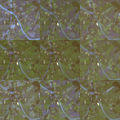

<IPython.core.display.Javascript object>

In [15]:
# print(d[1] / np.amax(d[1]) * 256)
image_R = pil_image.fromarray(d[1] / np.amax(d[1]) * 256).convert("L")
image_G = pil_image.fromarray(d[2] / np.amax(d[2]) * 256).convert("L")
image_B = pil_image.fromarray(d[3] / np.amax(d[3]) * 256).convert("L")

# print(image_R.mode)
pil_image.merge("RGB", (image_R, image_G, image_B))

Now lets start importing our training data to take a look at what's inside. We'll only use the ID, x, and y columns.

In [16]:

train_metadata = pd.read_csv(DATA_PATH + "train-unique.csv")
train_metadata.head()


,ID,Year,PlotSize_acres,Yield,Quality,x,y
0,id_ade6610c,2018,0.25,NaN,2,-0.100546,0.131002
1,id_c987f14e,2018,2.00,NaN,1,-0.985732,-0.032197
2,id_92e2cdbf,2016,1.00,0.37125,1,-1.335971,-1.069998
3,id_a1ce519e,2017,1.50,0.26875,3,0.000000,0.000000
4,id_fe53ff60,2018,0.25,NaN,1,0.173911,0.273041


<IPython.core.display.Javascript object>

We then separate the training data into data and labels, adding a column with the full filename for easy retrieval during training.

In [17]:
train_labels = train_metadata[["ID", "x", "y"]].copy()
train_labels.head()

,ID,x,y
0,id_ade6610c,-0.100546,0.131002
1,id_c987f14e,-0.985732,-0.032197
2,id_92e2cdbf,-1.335971,-1.069998
3,id_a1ce519e,0.000000,0.000000
4,id_fe53ff60,0.173911,0.273041


<IPython.core.display.Javascript object>

In [18]:
train_data = train_metadata.drop(columns=["x", "y"])
file_num = train_data["ID"]
train_data["file_name"] = [
    DATA_PATH + "sentinel/" + x[3:] + ".tif" for x in train_data["ID"]
]
train_data.head()

,ID,Year,PlotSize_acres,Yield,Quality,file_name
0,id_ade6610c,2018,0.25,NaN,2,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
1,id_c987f14e,2018,2.00,NaN,1,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
2,id_92e2cdbf,2016,1.00,0.37125,1,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
3,id_a1ce519e,2017,1.50,0.26875,3,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
4,id_fe53ff60,2018,0.25,NaN,1,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...


<IPython.core.display.Javascript object>

Now we get into the meat of the code. This is a PyTorch Lightning Dataset with some specific modifications:

1) During the transformation step, we will apply a random gaussian blur to augment the dataset and reduce overfitting. The other steps in the transform are necessary for optimal ResNet152 pretrained models.

2) __getitem__ contains the processing we need to load up the image like we tested out before.


In [19]:
class DatasetSentinel(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_train, y_train=None):
        self.data = x_train
        self.label = y_train
        self.transform = transforms.Compose(
            [
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                # All models expect the same normalization mean & std
                # https://pytorch.org/docs/stable/torchvision/models.html
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
                transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        d = getSentinelTimeData(self.data.iloc[index]["file_name"])

        image_R = pil_image.fromarray(d[1] / np.amax(d[1]) * 256).convert("L")
        image_G = pil_image.fromarray(d[2] / np.amax(d[2]) * 256).convert("L")
        image_B = pil_image.fromarray(d[3] / np.amax(d[3]) * 256).convert("L")
        image = pil_image.merge("RGB", (image_R, image_G, image_B))
        image = self.transform(image)
        image_id = self.data.iloc[index]["ID"]
        if self.label is not None:
            label_x = self.label.iloc[index]["x"]
            label_y = self.label.iloc[index]["y"]
            sample = {
                "image_id": image_id,
                "image": image,
                "label": np.array([label_x, label_y]),
            }
        else:
            sample = {"image_id": image_id, "image": image}
        return sample

<IPython.core.display.Javascript object>

The competition rules state we should use L1Loss so that's our loss module; boilerplate.

In [20]:
class L1Loss(nn.Module):
    """Measures absolute mean error."""

    def __init__(self):
        super(L1Loss, self).__init__()
        self.L1 = nn.L1Loss()

    def forward(self, pred, true):
        return self.L1(pred, true)

<IPython.core.display.Javascript object>

Here is the LightningModule for the model itself. We organize the hyperparameter inputs using the hparams object, set up logging, and define our datasets upon initialization.

Then we load the pretrained model in prepare model, changing the last layer (.fc) to remove softmax, this allows us to predict floating point values. The rest of the functions are standard and documented in the official PyTorch Lightning documentation.

The function make_submission_frame will generate the output file for our final prediction on the test set.

In [48]:
class PretrainedSentinelModel(pl.LightningModule):
    def __init__(self, hparams):
        super(PretrainedSentinelModel, self).__init__()
        self.hparams = hparams

        # hyperparameters for training the model with their default values as second argument
        self.learning_rate = self.hparams.get("lr", 2e-4)
        self.hidden_size = self.hparams.get("embedding_dim", 50)
        self.dropout = self.hparams.get("dropout", 0.1)
        self.max_epochs = self.hparams.get("max_epochs", 1)
        self.num_workers = self.hparams.get("num_workers", 0)
        self.batch_size = self.hparams.get("batch_size", 10)

        # our datasets
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")

        self.num_outputs = 2  # two predictions for field displacement

        # Where final model will be saved
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model-outputs")
        self.output_path.mkdir(exist_ok=True)

        # Where TensorBoard logs will be saved
        self.log_path = Path.cwd() / self.hparams.get("log_path", "logs")
        self.log_path.mkdir(exist_ok=True)
        self.logger = pl.loggers.TensorBoardLogger(
            self.log_path, name="benchmark_model"
        )

        # Instantiate training and validation datasets
        self.train_dataset = DatasetSentinel(self.x_train, self.y_train)
        self.val_dataset = DatasetSentinel(self.x_val, self.y_val)
        self.model = self.prepare_model()

    def prepare_model(self):
        res_model = models.resnet152(pretrained=True)
        # Input size of 2048 for resnet152
        # https://pytorch.org/hub/pytorch_vision_resnet/
        res_model.fc = nn.Sequential(
            nn.Linear(2048, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(self.hidden_size, self.num_outputs),
        )

        return res_model

    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]
        criterion = L1Loss()
        # Switch to training mode
        loss = criterion(
            self.model.train().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"train_loss": loss}
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"]

        criterion = L1Loss()
        # Switch to evaluation mode
        loss = criterion(
            self.model.eval().forward(x).squeeze(), y.type(torch.FloatTensor).cuda()
        )
        tensorboard_logs = {"val_loss": loss}
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return {"batch_val_loss": loss}

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    ## Convenience Methods ##

    def fit(self):
        self.trainer = pl.Trainer(
            max_epochs=self.max_epochs,
            default_root_dir=self.output_path,
            logger=self.logger,
            checkpoint_callback=pl.callbacks.ModelCheckpoint(
                filepath=self.output_path,
                monitor="val_loss_epoch",
                mode="min",
                verbose=True,
            ),
            gradient_clip_val=self.hparams.get("gradient_clip_val", 1),
            num_sanity_val_steps=self.hparams.get("val_sanity_checks", 0),
            gpus=1,
        )
        self.trainer.fit(self)

    @torch.no_grad()
    def make_submission_frame(self, x_test):
        test_dataset = DatasetSentinel(x_test)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        submission_frame = pd.DataFrame(index=x_test.ID, columns=["x", "y"])
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            x = batch["image"]
            preds = self.eval().forward(x)
            # print(batch["image_id"], preds, submission_frame)
            submission_frame.loc[batch["image_id"], ["x", "y"]] = (
                preds.detach().numpy().squeeze()
            )
        submission_frame.x = submission_frame.x.astype(float)
        submission_frame.y = submission_frame.y.astype(float)
        return submission_frame

<IPython.core.display.Javascript object>

Now we'll split into training and validation sets. We don't need any particular shuffling since we assume the data rows are independent. I have kfold crossvalidation commented out in case we want to use that later.

In [22]:
## import the KFold object from sklearn
#from sklearn.model_selection import KFold

## We'll need this when we fit models
from sklearn.base import clone

# kfold = KFold(n_splits=2, shuffle=True, random_state=440)

split =  int(len(train_data)*.8)
X_train = train_data.iloc[:split,:]
X_val= train_data.iloc[split+1:,:]
y_train = train_labels.iloc[:split,:]
y_val = train_labels.iloc[split:,:]

X_train.head()


,ID,Year,PlotSize_acres,Yield,Quality,file_name
0,id_ade6610c,2018,0.25,NaN,2,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
1,id_c987f14e,2018,2.00,NaN,1,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
2,id_92e2cdbf,2016,1.00,0.37125,1,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
3,id_a1ce519e,2017,1.50,0.26875,3,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
4,id_fe53ff60,2018,0.25,NaN,1,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...


<IPython.core.display.Javascript object>

Now it's time to run the model. For hyperparameter explanation please see the documentation for PyTorch. 

In [23]:
# You can loop through all the splits like so
# for i in range(2):

# result = next(kfold.split(X), None)

# X_train, X_val = X.iloc[result[0]], X.iloc[result[1]]
# y_train, y_val = y.iloc[result[0]], y.iloc[result[1]]

hparams = {
    # Required hparams
    "x_train": X_train,
    "y_train": y_train,
    "x_val": X_val,
    "y_val": y_val,
    # Optional hparams
    "lr": 2e-4,
    "embedding_dim": 100,
    "dropout": 0.5,
    "max_epochs": 20,
    "batch_size": 10,
    "num_workers": 0,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

# best_checkpoint = str(Path("model-outputs") / "epoch=8-step=40481.ckpt")
Sentinel_model = PretrainedSentinelModel(hparams=hparams)
# storm_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)
Sentinel_model.fit()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.3 M
---------------------------------
58.3 M    Trainable params
0         Non-trainable params
58.3 M    Total params


Epoch 0, global step 29: val_loss_epoch reached 0.18508 (best 0.18508), saving model to "C:\Users\micha\OneDrive\Documents\GitHub\CNN\model-outputs\epoch=0-step=29-v0.ckpt" as top 1


Epoch 1, global step 59: val_loss_epoch reached 0.16742 (best 0.16742), saving model to "C:\Users\micha\OneDrive\Documents\GitHub\CNN\model-outputs\epoch=1-step=59-v0.ckpt" as top 1


Epoch 2, global step 89: val_loss_epoch reached 0.16433 (best 0.16433), saving model to "C:\Users\micha\OneDrive\Documents\GitHub\CNN\model-outputs\epoch=2-step=89-v0.ckpt" as top 1


Epoch 3, step 119: val_loss_epoch was not in top 1
C:\Users\micha\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 4, step 131: val_loss_epoch was not in top 1


<IPython.core.display.Javascript object>

Now it's time to test our model. We'll load up the test CSV file and create the file names just like for the training data.

In [38]:

test_data = pd.read_csv(DATA_PATH + "test.csv")
file_num = test_data["ID"]
test_data["file_name"] = [
    DATA_PATH + "sentinel/" + x[3:] + ".tif" for x in test_data["ID"]
]
test_data.head()


,ID,Year,PlotSize_acres,Yield,file_name
0,id_e7032b10,2016,0.50,0.0,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
1,id_ae7cb51e,2018,1.00,NaN,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
2,id_e59f7730,2018,1.00,NaN,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
3,id_b9011c86,2018,1.50,NaN,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...
4,id_caaeb9f8,2018,0.25,NaN,C:/Users/micha/OneDrive/Documents/GitHub/Lacun...


<IPython.core.display.Javascript object>

Now we load up the best performing checkpoint and run the model once on the test data using the make_submission_frame method.

In [49]:

best_checkpoint = str(Path("model-outputs") / "epoch=2-step=89-v0.ckpt")
Sentinel_model = PretrainedSentinelModel.load_from_checkpoint(best_checkpoint)
submission = Sentinel_model.make_submission_frame(test_data)

100%|████████████████████████████████████████████████████████████████████████████████| 162/162 [08:37<00:00,  3.19s/it]


,x,y
count,1613.000000,1613.000000
mean,0.003179,-0.011797
std,0.022213,0.054799
min,-0.102192,-0.305071
25%,-0.002403,-0.029283
50%,0.005216,-0.005797
75%,0.014711,0.013140
max,0.137384,0.142543


<IPython.core.display.Javascript object>

Let's compare some statistics on our predicted displacements versus the known training displacements.

In [51]:
print("Test Prediction Distribution")
submission.describe()

Test Prediction Distribution


,x,y
count,1613.000000,1613.000000
mean,0.003179,-0.011797
std,0.022213,0.054799
min,-0.102192,-0.305071
25%,-0.002403,-0.029283
50%,0.005216,-0.005797
75%,0.014711,0.013140
max,0.137384,0.142543


<IPython.core.display.Javascript object>

In [52]:
print("training Prediction Distribution")
train_labels.describe()

training Prediction Distribution


,x,y
count,366.000000,366.000000
mean,-0.016858,-0.015343
std,0.297545,0.289215
min,-1.335971,-1.310685
25%,-0.159259,-0.149642
50%,0.000000,0.000000
75%,0.135086,0.133186
max,1.112720,1.176673


<IPython.core.display.Javascript object>

As you can see, the model is very conservative and often makes little to no correction in the position. This suggests that the performance could be improved significantly if we could add more information to the data, or build an ensemble with other models.

In [ ]:
submission.to_csv((DATA_PATH / "temporalsubmission.csv"), index=True)